In [ ]:
!pip install np_utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from keras import initializers
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras import backend as K
import tensorflow as tf
from keras.layers import Dropout
from keras.datasets import cifar10

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170508288/170498071 [==============================] - 3s 0us/step


In [3]:
X_train = np.float32(X_train)
X_train = (X_train - 127.5) / 127.5

In [4]:
# init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()
# foundation for 4x4 image
n_nodes = 256 * 4 * 4
generator.add(Dense(n_nodes, input_dim=100))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((4, 4, 256)))
# upsample to 8x8
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# upsample to 16x16
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# upsample to 32x32
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# output layer
generator.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

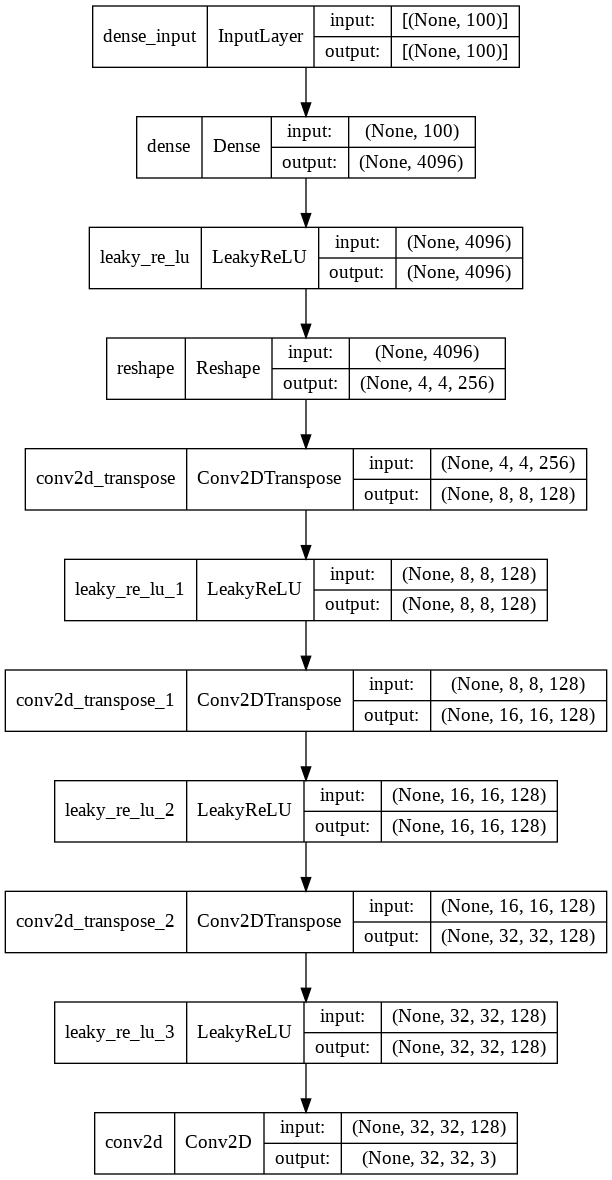

In [ ]:
plot_model(generator, show_shapes=True)

In [5]:
# Discriminator network
discriminator = Sequential()
	# normal
discriminator.add(Conv2D(64, (3,3), padding='same', input_shape=X_train[0].shape))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# classifier
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))
# compile model

opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


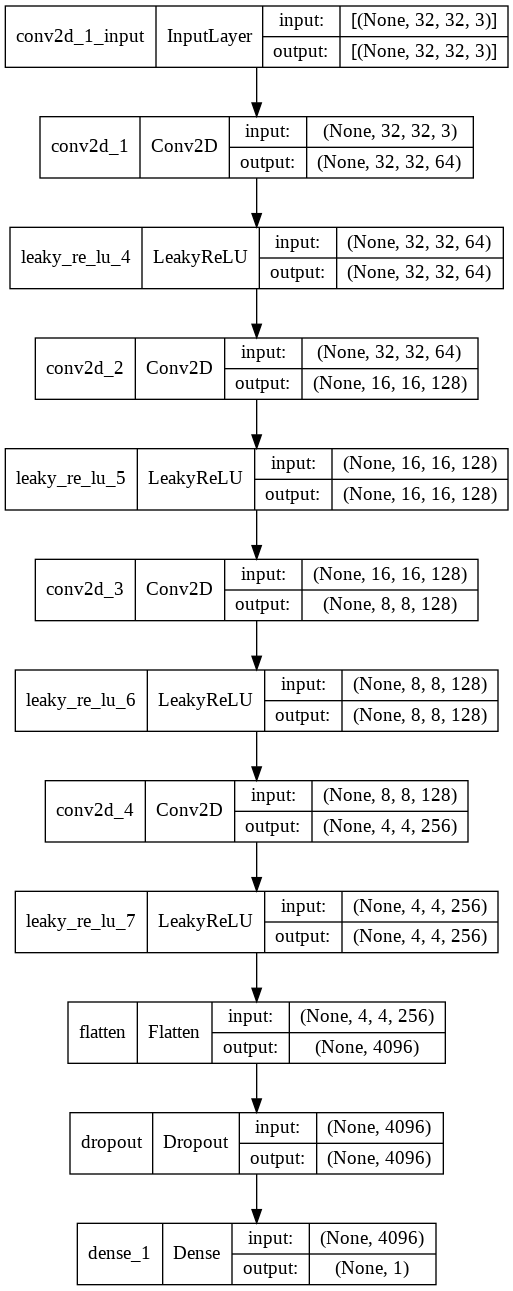

In [ ]:
plot_model(discriminator, show_shapes=True)

In [6]:
discriminator.trainable = False
z = Input(shape=(100,))
img = generator(z)
decision = discriminator(img)
GAN = Model(inputs=z, outputs=decision)
GAN.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch = 1/51


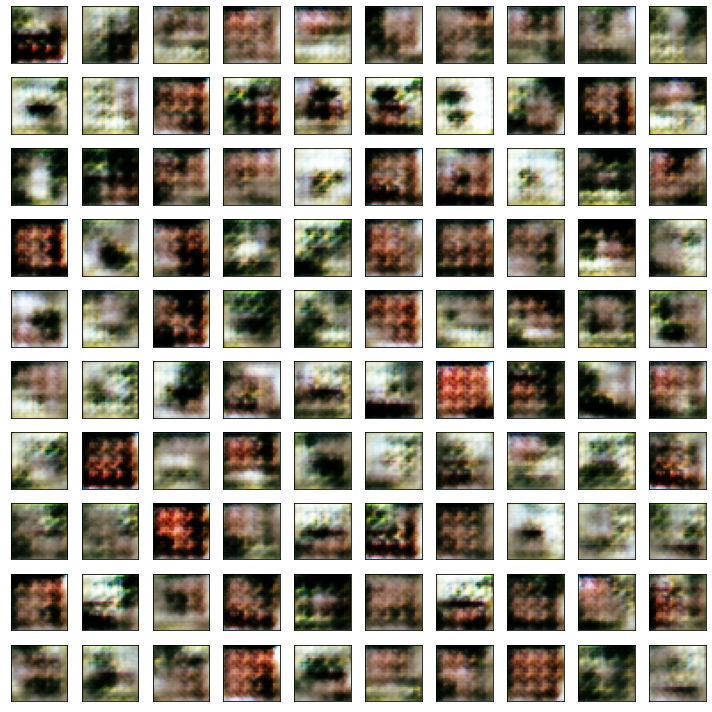

epoch = 2/51
epoch = 3/51
epoch = 4/51
epoch = 5/51
epoch = 6/51
epoch = 7/51
epoch = 8/51
epoch = 9/51
epoch = 10/51
epoch = 11/51


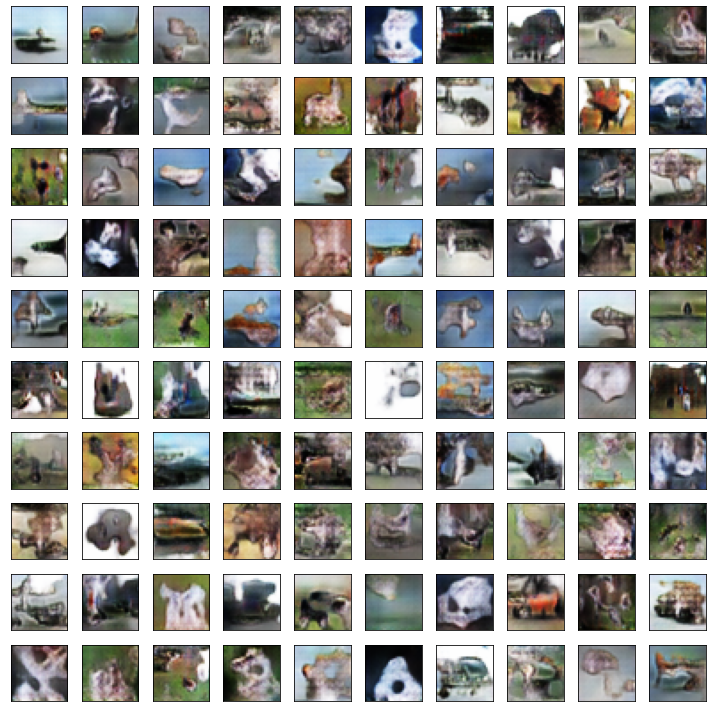

epoch = 12/51
epoch = 13/51
epoch = 14/51
epoch = 15/51
epoch = 16/51
epoch = 17/51
epoch = 18/51
epoch = 19/51
epoch = 20/51
epoch = 21/51


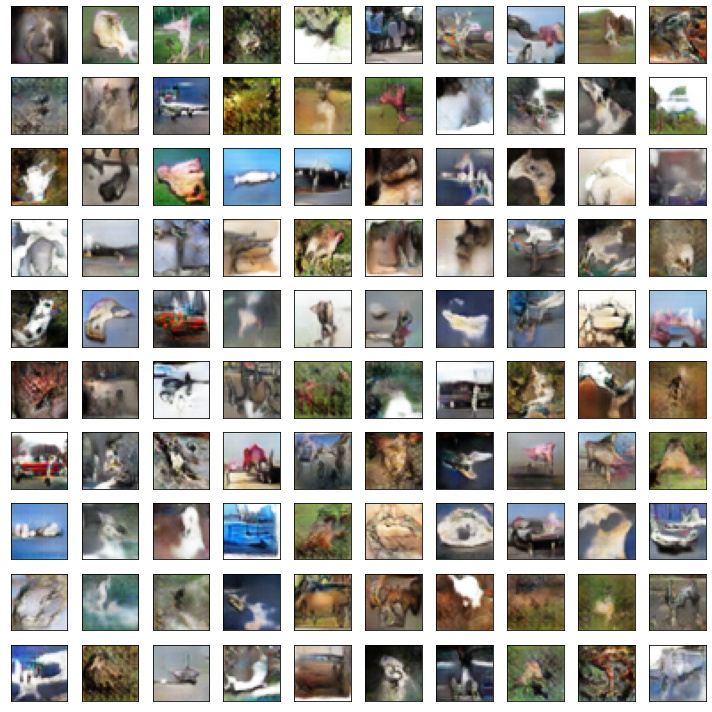

KeyboardInterrupt: ignored

In [7]:
epochs = 51
batch_size = 32

def noisy_labels(y, p_flip):
	n_select = int(p_flip * y.shape[0])
	flip_ix = np.random.choice([i for i in range(y.shape[0])], size=n_select)
	y[flip_ix] = 1 - y[flip_ix]
	return y

y_real = np.ones(shape=(batch_size, 1))
y_real = noisy_labels(y_real, 0.05)
y_fake = np.zeros(shape=(batch_size, 1))
y_fake = noisy_labels(y_fake, 0.05)

d_loss = []
g_loss = []

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
        # discriminator learn real
        discriminator.trainable = True
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        # d_loss_real = discriminator.train_on_batch(x=X_batch,y=y_real*0.9)
        d_loss_real = discriminator.train_on_batch(x=X_batch,y=y_real)

        #produce random number
        z = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
        #generator generates fake
        X_fake = generator.predict_on_batch(z)
        #discriminator learn fake
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=y_fake)
        #mean of fake and real loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        discriminator.trainable = False
        #train generator
        g_loss_batch = GAN.train_on_batch(x=z, y=y_real)

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d' % (e + 1, epochs))

    #plot 10x10 pictures 
    if e % 10 == 0:
        samples = 100
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
        
        fig = plt.figure(figsize=(10,10))
        for k in range(samples):
            plt.subplot(10,10, k + 1, xticks=[], yticks=[])
            plt.imshow((x_fake[k] + 1)/2)
            plt.tight_layout()
        plt.show()

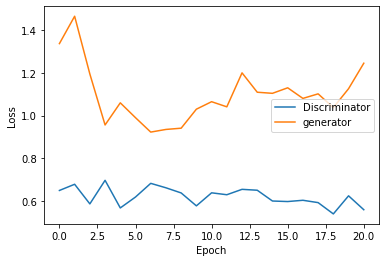

In [8]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'generator'], loc='center right')
plt.show()